# **Unsupervised Learning**

---

This part of the notebook contains an unsupervised analysis structured as follows:

- We start by visualizing the data using **UMAP**, following the standard pipeline of first reducing the dimensionality using **PCA** and then applying UMAP to generate low-dimensional embeddings. 

- Next, we perform a first unsupervised classification using **k-means clustering**, and we compare the clusters we obtain with the **true biological labels** (for example, Normoxia vs. Hypoxia).

- In the final part, we also apply a **hierarchical clustering approach** and visualize the results using dendrograms to better understand the relationships between samples.

This analysis aims to explore the structure and separability of the data without relying on supervision, providing insights into how well unsupervised methods align with the known biological conditions.


## Index

1. [Load Datasets](#1-load-datasets)  
2. [Functions Definition](#2-function-definition)
3. [PCA](#3-PCA) 
4. [UMAP and clustering](#4-umap-and-k-means-clustering)  
5. [Hierachical clustering](#5-hierarchical-clustering)


In [1]:
import os
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap
from sklearn.decomposition import PCA
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## **1.** Load Datasets
---

In [2]:
dfs_hcc_train = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"'))
dfd_hcc_train = pd.read_csv("../Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"'))

## **2.** Functions Definition
---


function to extract labels

In [3]:
def extract_conditions(sample_names):
    """
    Extracts 'Normoxia' or 'Hypoxia' labels from a list or pandas Series of sample names.

    Parameters:
    - sample_names: list or pandas Series of sample names (e.g., column names)

    Returns:
    - conditions: pandas Series with 'Normoxia' or 'Hypoxia' labels
    """
    # Ensure input is a pandas Series
    if not isinstance(sample_names, pd.Series):
        sample_names = pd.Series(sample_names)

    # Detect condition based on presence of 'Hypo' (case-insensitive)
    conditions = sample_names.str.contains('Hypo', case=False).map({True: 'Hypoxia', False: 'Normoxia'})

    print("Condition counts:\n", conditions.value_counts())

    return conditions

In [4]:
# For HCC1806 SmartSeq
sample_names_hcc = dfs_hcc_train.columns
conditions_hcc = extract_conditions(sample_names_hcc)
print("\nHCC1806 SmartSeq conditions:\n", conditions_hcc.head())


# For HCC1806 DropSeq
sample_names_d_hcc = dfd_hcc_train.columns
conditions_d_hcc = extract_conditions(sample_names_d_hcc)
print("\nHCC1806 DropSeq conditions:\n", conditions_d_hcc.head())

Condition counts:
 Hypoxia     97
Normoxia    85
Name: count, dtype: int64

HCC1806 SmartSeq conditions:
 0    Normoxia
1     Hypoxia
2     Hypoxia
3     Hypoxia
4     Hypoxia
dtype: object
Condition counts:
 Normoxia    12705
Hypoxia      8921
Name: count, dtype: int64

HCC1806 DropSeq conditions:
 0    Normoxia
1    Normoxia
2    Normoxia
3    Normoxia
4    Normoxia
dtype: object


In [5]:
# PCA function
def run_pca_on_dataframe(df, dataset_name="dataset", n_components=None):
    """
    Runs PCA on a DataFrame (genes x cells), plots variance and cumulative variance.

    Parameters:
    - df: pandas DataFrame (genes x cells)
    - dataset_name: name used in plot titles
    - n_components: number of principal components (default: all)
    
    Returns:
    - pca: fitted PCA object
    - X_pca: transformed data (numpy array, cells x components)
    """
    # Step 1: Prepare data (cells × genes)
    data = df.T.to_numpy()
    print(f"{dataset_name} matrix shape (cells x genes): {data.shape}")

    # Step 2: Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data)
    print(f"PCA result shape (cells x components): {X_pca.shape}")

    # Step 3: Explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_,
             marker='o', linewidth=2)
    plt.title(f"Explained Variance per PC ({dataset_name})")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 4: Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(cumulative_variance) + 1),
             cumulative_variance,
             marker='o', linewidth=2)
    plt.axhline(y=0.70, color='yellow', linestyle='--', label='70% variance threshold')
    plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance threshold')
    plt.title(f"Cumulative Explained Variance ({dataset_name})")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca, X_pca

In [6]:
def pca_optimal_clustering_umap_pipeline(df, true_labels, dataset_name="dataset",
                                         cluster_range=range(2, 10), variance_threshold=0.95,
                                         method='kmeans', random_state=42):
    """
    Runs PCA, selects optimal number of clusters (by silhouette), applies clustering, runs UMAP, and plots:
    (1) clusters on UMAP
    (2) true labels on UMAP

    Parameters:
    - df: pandas DataFrame (genes x cells)
    - true_labels: array-like, known labels (e.g., Normoxia/Hypoxia)
    - dataset_name: title for plots
    - cluster_range: range of cluster numbers to test
    - variance_threshold: PCA variance coverage
    - method: 'kmeans' or 'hierarchical'
    - random_state: reproducibility

    Returns:
    - best_cluster_labels: array of best cluster assignments
    - X_umap_2d: UMAP embedding (2D)
    - best_n_clusters: selected optimal number of clusters
    """
    X = df.T.to_numpy()

    # --- PCA ---
    pca = PCA()
    X_pca = pca.fit_transform(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Selected {n_components} PCs to cover {variance_threshold * 100:.0f}% variance")

    X_pca_reduced = X_pca[:, :n_components]

    # --- Find optimal number of clusters ---
    best_score = -1
    best_n_clusters = None
    best_cluster_labels = None

    for n_clusters in cluster_range:
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        elif method == 'hierarchical':
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
        else:
            raise ValueError("method must be 'kmeans' or 'hierarchical'")

        cluster_labels = clusterer.fit_predict(X_pca_reduced)

        # Only compute silhouette if more than 1 cluster
        if len(np.unique(cluster_labels)) > 1:
            score = silhouette_score(X_pca_reduced, cluster_labels)
            print(f"n_clusters={n_clusters}: silhouette score = {score:.4f}")

            if score > best_score:
                best_score = score
                best_n_clusters = n_clusters
                best_cluster_labels = cluster_labels

    print(f"\nOptimal number of clusters: {best_n_clusters} (silhouette = {best_score:.4f})")
    print(f"Cluster label counts:\n{np.bincount(best_cluster_labels)}")

    # --- UMAP (2D) ---
    umap_model = umap.UMAP(n_components=2, random_state=random_state)
    X_umap_2d = umap_model.fit_transform(X_pca_reduced)

    # --- Plot UMAP with optimal cluster colors ---
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_umap_2d[:, 0],
        X_umap_2d[:, 1],
        c=best_cluster_labels,
        cmap='tab10',
        s=10,
        alpha=0.7
    )
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                                 markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
                      for i in np.unique(best_cluster_labels)]
    plt.legend(handles=legend_handles, title='Optimal Clusters')
    plt.title(f"Optimal {method.capitalize()} Clustering (n={best_n_clusters}) on UMAP ({dataset_name})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.tight_layout()
    plt.show()

    # --- Plot UMAP with true label colors ---
    color_map = {'Normoxia': 'blue', 'Hypoxia': 'red'}
    label_colors = np.array([color_map.get(label, 'gray') for label in true_labels])

    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_umap_2d[:, 0],
        X_umap_2d[:, 1],
        c=label_colors,
        s=10,
        alpha=0.7
    )
    for label_name, color in color_map.items():
        plt.scatter([], [], c=color, label=label_name, s=30)
    plt.legend(title='True Labels')
    plt.title(f"True Labels Visualized on UMAP ({dataset_name})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.tight_layout()
    plt.show()

    return best_cluster_labels, X_umap_2d, best_n_clusters

In [7]:
import re
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

def run_hierarchical_clustering_short_labels(df, labels, dataset_name="dataset", method='ward', metric='euclidean'):
    """
    Runs hierarchical clustering and plots a dendrogram with shortened sample labels colored by condition.
    """
    data = df.T

    # Shorten sample names (customize this regex to your naming!)
    short_names = data.index.to_series().apply(lambda x: re.sub(r'output\.STAR\.\d+_', '', x).split('_Aligned')[0])

    # Calculate distance + linkage
    print(f"Calculating pairwise distances on {dataset_name}...")
    dists = pdist(data, metric=metric)
    linkage_matrix = sch.linkage(dists, method=method)

    # Build color map for labels
    color_map = {'Normoxia': 'blue', 'Hypoxia': 'red'}
    label_colors = {short: color_map.get(label, 'gray') for short, label in zip(short_names, labels)}

    # Plot dendrogram
    fig, ax = plt.subplots(figsize=(16, 6))
    dendro = sch.dendrogram(
        linkage_matrix,
        labels=short_names,
        leaf_rotation=90,
        leaf_font_size=6,
        ax=ax
    )

    # Color tick labels
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        sample_name = lbl.get_text()
        lbl.set_color(label_colors.get(sample_name, 'gray'))

    # Add legend
    for label_name, color in color_map.items():
        ax.scatter([], [], c=color, label=label_name, s=50, edgecolors='k')
    ax.legend(title='Condition', loc='upper right')

    ax.set_title(f"Hierarchical Clustering Dendrogram ({dataset_name})")
    ax.set_xlabel("Samples")
    ax.set_ylabel(f"{method.capitalize()} distance")
    plt.tight_layout()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

def run_hierarchical_clustering_compare(df, labels, dataset_name="dataset",
                                        methods=('ward', 'complete'), metric='euclidean'):
    """
    Runs hierarchical clustering using two linkage methods and compares their dendrograms.
    
    Parameters:
    - df: DataFrame (genes x samples)
    - labels: list of true labels (e.g., Normoxia/Hypoxia)
    - dataset_name: string, title for the plots
    - methods: tuple of two linkage methods to compare (e.g., ('ward', 'complete'))
    - metric: distance metric (e.g., 'euclidean')
    """
    data = df.T
    short_names = data.index.to_series().apply(lambda x: re.sub(r'output\.STAR\.\d+_', '', x).split('_Aligned')[0])

    # Label coloring
    color_map = {'Normoxia': 'blue', 'Hypoxia': 'red'}
    label_colors = {short: color_map.get(label, 'gray') for short, label in zip(short_names, labels)}

    # Prepare distance matrix once
    print(f"Calculating pairwise distances on {dataset_name} using '{metric}' metric...")
    dists = pdist(data, metric=metric)

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(22, 15))
    for i, method in enumerate(methods):
        linkage_matrix = sch.linkage(dists, method=method)

        dendro = sch.dendrogram(
            linkage_matrix,
            labels=short_names,
            leaf_rotation=90,
            leaf_font_size=6,
            ax=axes[i]
        )

        xlbls = axes[i].get_xmajorticklabels()
        for lbl in xlbls:
            sample_name = lbl.get_text()
            lbl.set_color(label_colors.get(sample_name, 'gray'))

        axes[i].set_title(f"{method.capitalize()} Linkage")
        axes[i].set_xlabel("Samples")
        axes[i].set_ylabel(f"{method.capitalize()} Distance")

    # Shared legend
    for label_name, color in color_map.items():
        axes[1].scatter([], [], c=color, label=label_name, s=50, edgecolors='k')
    axes[1].legend(title='Condition', loc='upper right')

    plt.suptitle(f"Hierarchical Clustering Comparison ({dataset_name})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## **3.** PCA
---
In this section, we perform a full **Principal Component Analysis (PCA)** on each dataset.

We plot:
- The **explained variance per principal component**  
- The **cumulative explained variance** across components

This helps us understand how many components are needed to capture a desired fraction of the total variance, and it guides our dimensionality reduction steps before applying further analyses like UMAP or clustering.

HCC1806 SmartSeq matrix shape (cells x genes): (182, 3000)
PCA result shape (cells x components): (182, 182)


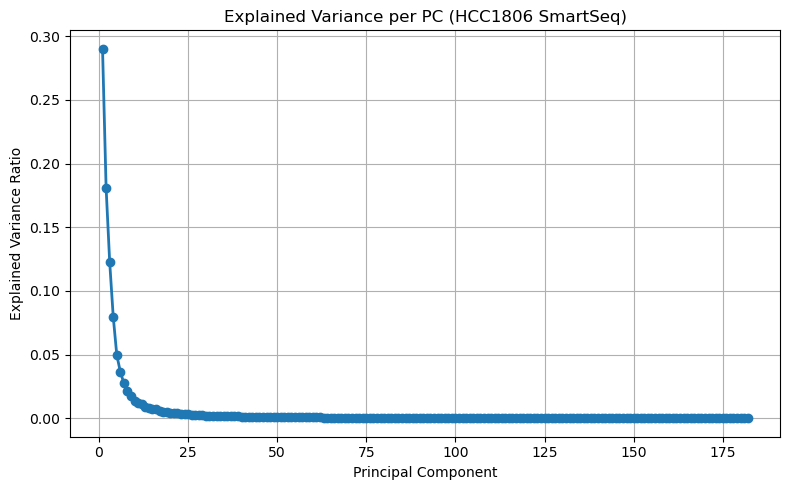

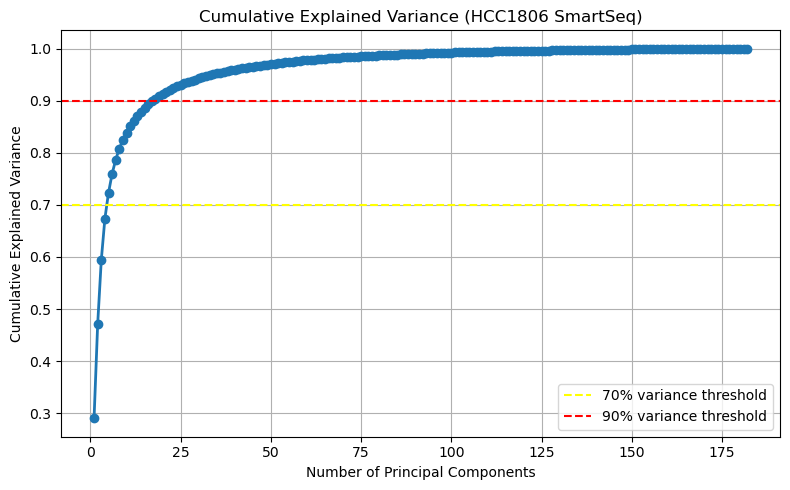

HCC1806 DropSeq matrix shape (cells x genes): (21626, 3000)
PCA result shape (cells x components): (21626, 3000)


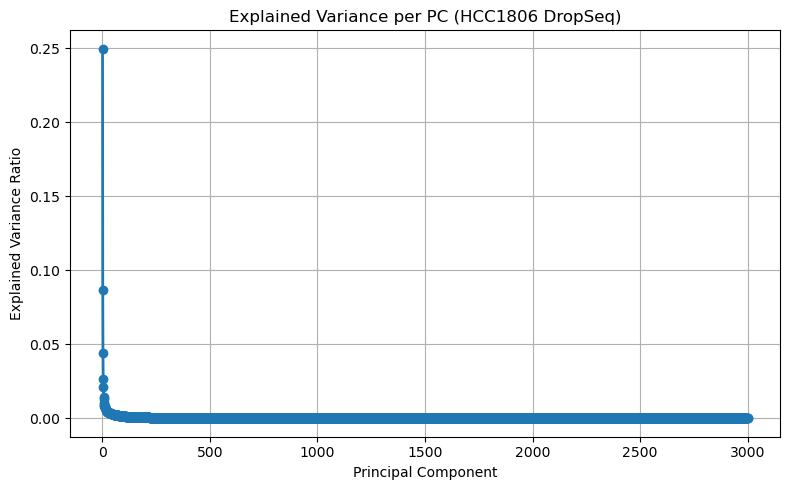

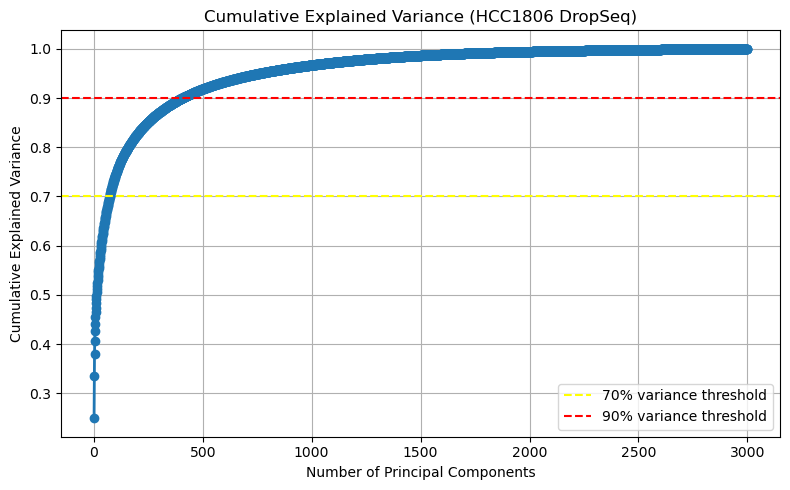

In [9]:
# HCC1806 SmartSeq
pca_hcc, X_hcc_pca = run_pca_on_dataframe(
    dfs_hcc_train,
    dataset_name="HCC1806 SmartSeq"
)

# HCC1806 DropSeq
pca_d_hcc, X_d_hcc_pca = run_pca_on_dataframe(
    dfd_hcc_train,
    dataset_name="HCC1806 DropSeq"
)

## **4.** UMAP and K-Means Clustering
---

In this section, we will perform UMAP and K-means clustering. For each dataset, we use as treshold for the number of PCs the 95% of explained variance. On the reduced datsets we will apply umap, to have a first visualization of the datsets. Then, we will perform K-means clustering as a first unsupervised classification method. The right number of clusters will be choosen with respect to the silhouette score. In the plots below on the umap graph we first show the true labels and then the labels of cluster found by the k-means clustering.

Selected 34 PCs to cover 95% variance
n_clusters=2: silhouette score = 0.2635
n_clusters=3: silhouette score = 0.1617
n_clusters=4: silhouette score = 0.1721
n_clusters=5: silhouette score = 0.1816
n_clusters=6: silhouette score = 0.1190
n_clusters=7: silhouette score = 0.1226
n_clusters=8: silhouette score = 0.1838
n_clusters=9: silhouette score = 0.1577

Optimal number of clusters: 2 (silhouette = 0.2635)
Cluster label counts:
[ 53 129]


/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


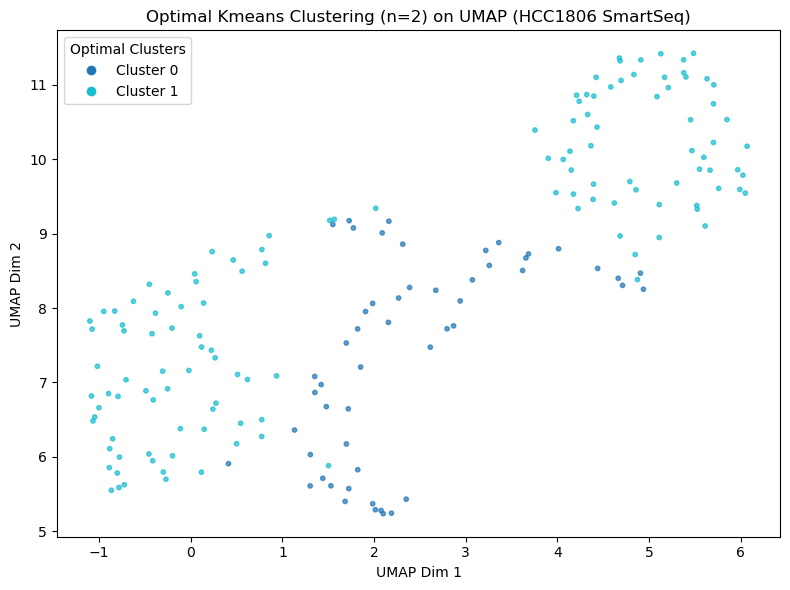

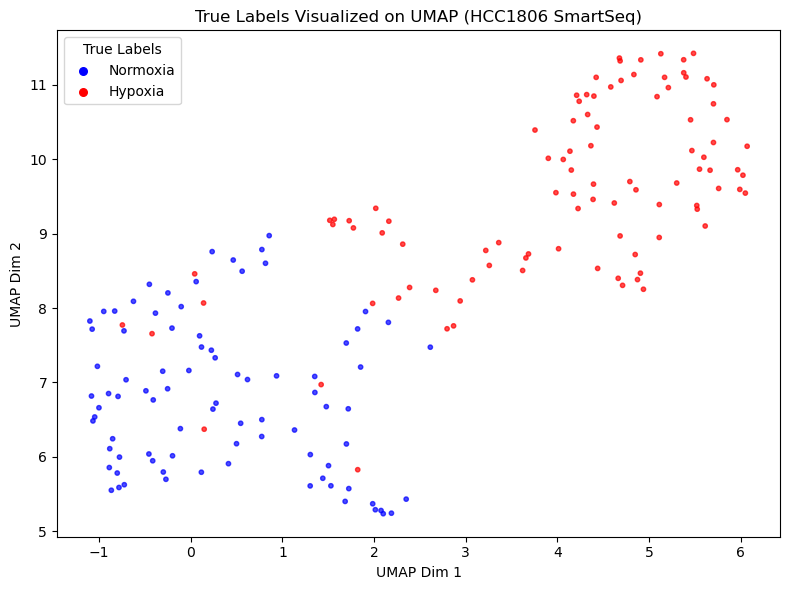

In [14]:
best_clusters, X_umap_2d, best_n = pca_optimal_clustering_umap_pipeline(
    dfs_hcc_train,
    true_labels=conditions_hcc.values,
    dataset_name="HCC1806 SmartSeq",
    cluster_range=range(2, 10),  # tries from 2 to 9 clusters
    method='kmeans'
)

Selected 761 PCs to cover 95% variance
n_clusters=2: silhouette score = 0.3261
n_clusters=3: silhouette score = 0.1298
n_clusters=4: silhouette score = 0.1158
n_clusters=5: silhouette score = 0.0758
n_clusters=6: silhouette score = 0.0728
n_clusters=7: silhouette score = 0.0594
n_clusters=8: silhouette score = 0.0567
n_clusters=9: silhouette score = 0.0510

Optimal number of clusters: 2 (silhouette = 0.3261)
Cluster label counts:
[20171  1455]


/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


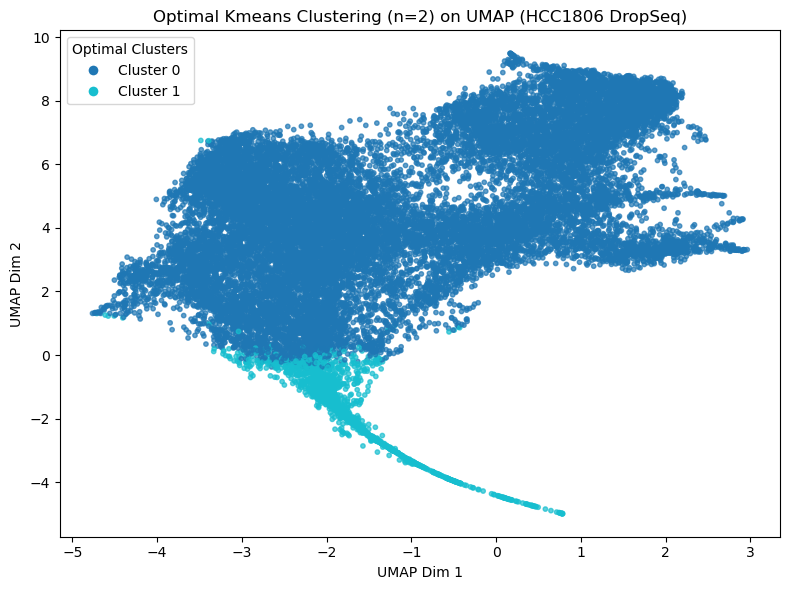

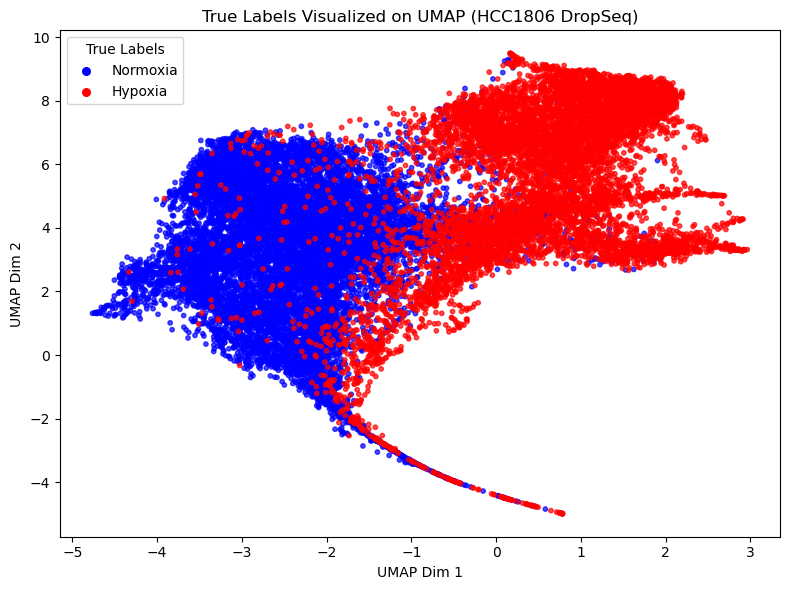

In [15]:
best_clusters, X_umap_2d, best_n = pca_optimal_clustering_umap_pipeline(
    dfd_hcc_train,
    true_labels=conditions_d_hcc.values,
    dataset_name="HCC1806 DropSeq",
    cluster_range=range(2, 10),  # tries from 2 to 9 clusters
    method='kmeans'
)

## **5.** Hierarchical Clustering

We applied hierarchical agglomerative clustering to the HCC1806 SmartSeq dataset to uncover the structure of gene expression under normoxic and hypoxic conditions. This method is particularly suited for RNA-seq data as it does not require a predefined number of clusters and provides an intuitive dendrogram representation of sample relationships. Using both Ward’s and average linkage, we observed a clear separation between the two conditions, with Ward’s method yielding more compact and distinct clusters. 

Calculating pairwise distances on MCF7 SmartSeq using 'euclidean' metric...


/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:3414: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ivl.append(labels[int(i - n)])
/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:3414: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ivl.append(labels[int(i - n)])


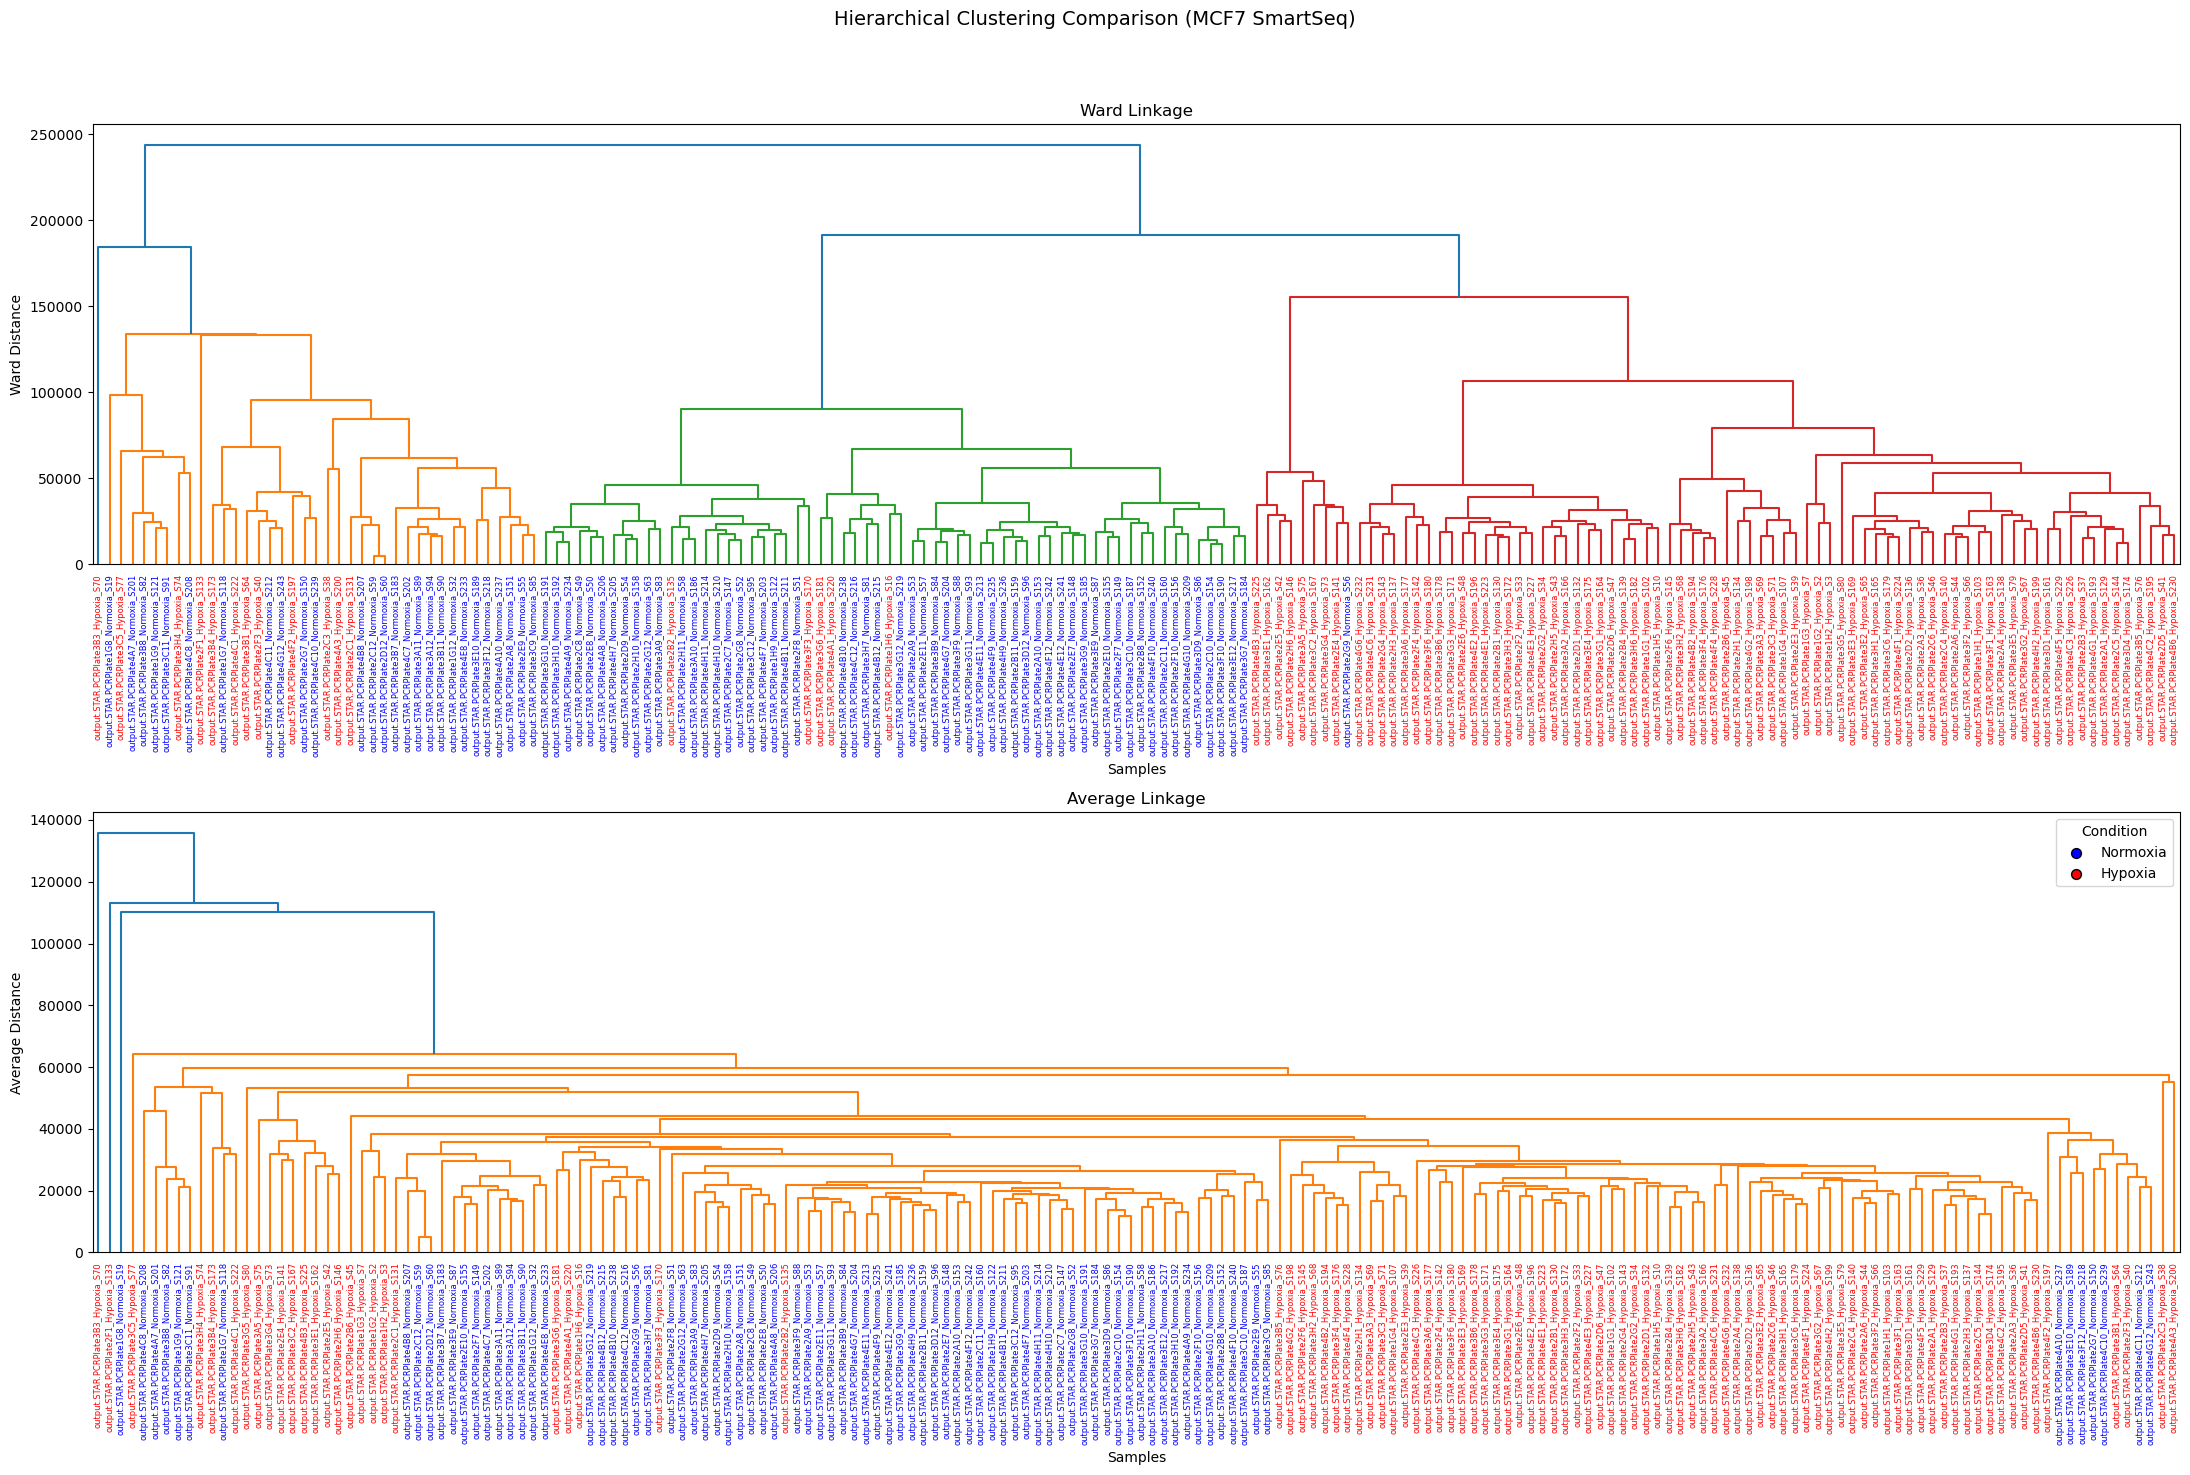

In [12]:
methods_to_compare = ('ward', 'average')
run_hierarchical_clustering_compare(dfs_hcc_train, conditions_hcc.values, "HCC1806 SmartSeq", methods=methods_to_compare)